# SUSTAINABLE MOBILITY

Group members:
- Carles Alfageme: s212750
- Joost Benrath: s212696
- Elena Vico: s12369

# Appendices
## Apendix 1

In [1]:
import numpy as np
import pandas as pd

In [2]:
#Function for creting lagged features
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

## Appendix 2

In [3]:
def compute_error(y_true, y_pred, nvariables = 2):
    mae = np.mean(np.abs(y_pred - y_true))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    r_squared = max(0, 1 - np.sum((y_true-y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    adjustedr2 = 1 - (1-r_squared)*(len(y_true)-1)/(len(y_true)-nvariables-1)
    return  mae, mape, rmse, r_squared, adjustedr2

# Section1: Introduction + Data analysis and visualization

This project consists in using data from Citi Bike (New York), one of the biggest station-based bike-sharing systems in the United States. The dataset includes more than 900 stations and 14000 bikes, and it contains over 17 million bike rides observed during 2018. This dataset has the general objective of helping City Bike operating at its best and of making bike sharing more attractive. On that purpose, the project is going to contain a prediction challenge where the number of pickups for the next 24 hours need to be predicted and an exploratory component where data is going to be analysed in order to determine causes that influence the number of pickups. 

In [4]:
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

In [5]:
# plot styles
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

In [6]:
df=pd.read_csv('Trips_2018.csv')
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992.0,1.0
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969.0,1.0
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956.0,1.0
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974.0,1.0
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992.0,1.0


## Data Cleaning

First, the dataset needs to be cleaned and some variables are going to be transformed. Missing values are going to be corrected or dropped. Categorical features are going to be transformed in order to get better data for the predictions.

Deleting the useless column Unnamed: 0 and transforming start and stop times to datetime objects:

In [7]:
df=df.drop(columns='Unnamed: 0')
df['starttime']=pd.to_datetime(df['starttime'],format='%Y-%m-%d %H:%M:%S')
df['stoptime']=pd.to_datetime(df['stoptime'],format='%Y-%m-%d %H:%M:%S')

Deleting rows with NaN values and transforming float variables to int:

In [8]:
df=df.dropna()
df['start_station_id']=df['start_station_id'].astype(int)
df['end_station_id']=df['end_station_id'].astype(int)
df['bikeid']=df['bikeid'].astype(int)
df['birth_year']=df['birth_year'].astype(int)

Apparently, there are some geographical coordinates that doesn't correspond to New York, but to Canada. They are then going to be removed. 

<function matplotlib.pyplot.show(close=None, block=None)>

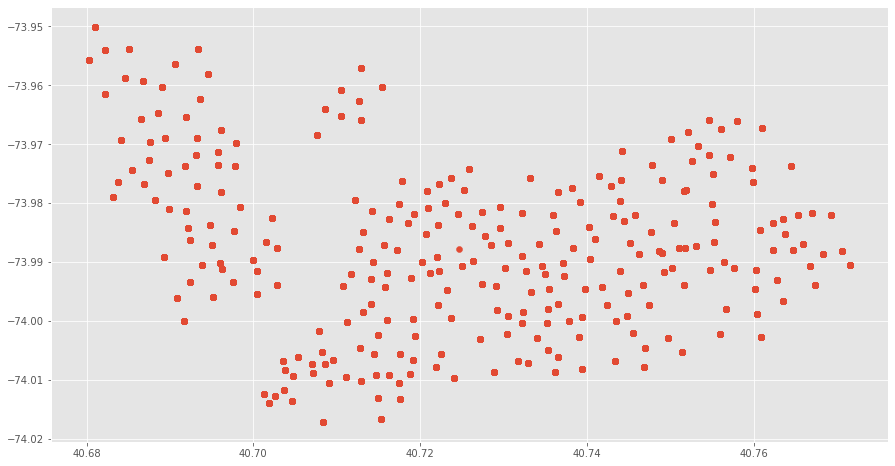

In [9]:
plt.scatter(df['start_station_latitude'],df['start_station_longitude'])
plt.show

In [10]:
df=df[df['start_station_latitude']<43]
df=df[df['end_station_latitude']<43]

It has been observed that some trip durations have values that just can be explained as errors in the data. It is impossible that trip durations can be of thousands of hours. To remove the outliers, it is going to be considered that durations of more than 24h are errors.

In [11]:
duration_max=24*3600
df=df[df['tripduration']<duration_max]

Performing a one-out-of K encoding to categorical features:

In [12]:
df=pd.get_dummies(df,columns=['usertype','gender'],drop_first=False)
df=df.rename(columns={'gender_0.0':'gender_unknown','gender_1.0':'gender_male','gender_2.0':'gender_female'})

Data preparation

In [13]:
df['date']=[d.date() for d in df['starttime']]
df['hour']=[d.hour for d in df['starttime']]
df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
df['pickup']=1

## Data analysis and visualization

### Number of pickups per month

In [14]:
pickups_months=df.groupby(df['date'].dt.month)['date'].count()
months=['January','February','March','April','May','June','July','August','September','October','November','December']

<Figure size 1080x576 with 0 Axes>

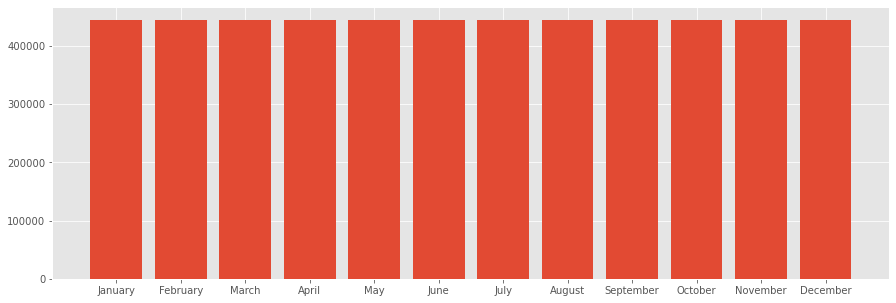

In [15]:
plt.figure(1)
plt.figure(figsize=(15,5))
plt.bar(months,pickups_months.values)
plt.show()

###  Total number of pickups per hour during the year

<Figure size 1080x576 with 0 Axes>

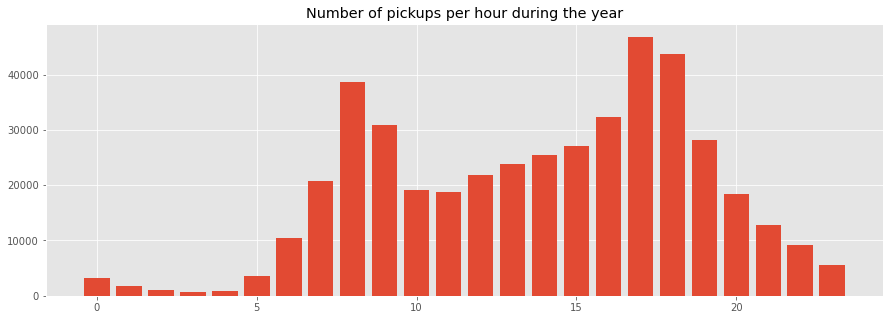

In [16]:
pickups_hour=df.groupby(['hour'])['hour'].count()
plt.figure(2)
plt.figure(figsize=(15,5))
plt.bar(pickups_hour.index,pickups_hour.values)
plt.title('Number of pickups per hour during the year')
plt.show()

### Average number of pickups per hour

In [17]:
average_pickups_hour=df.groupby(['date','hour'])['hour'].count()
average_pickups_hour=pd.DataFrame(average_pickups_hour)
average_pickups_hour=average_pickups_hour.rename(columns={'hour':'pickups'})
average_pickups_hour=average_pickups_hour.groupby(['hour']).mean()

<Figure size 1080x576 with 0 Axes>

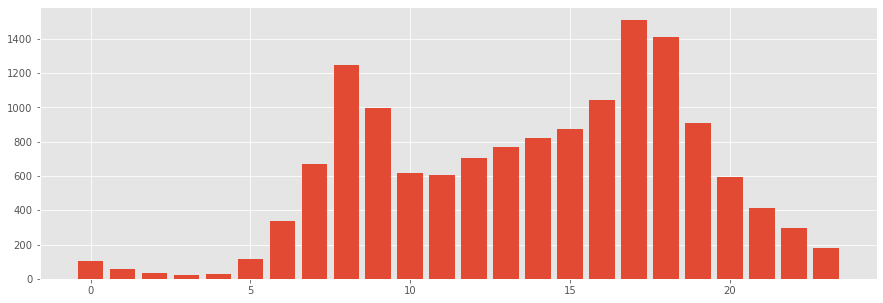

In [18]:
plt.figure(3)
plt.figure(figsize=(15,5))
plt.bar(average_pickups_hour.index,average_pickups_hour['pickups'])
plt.show()

### Pickups per day

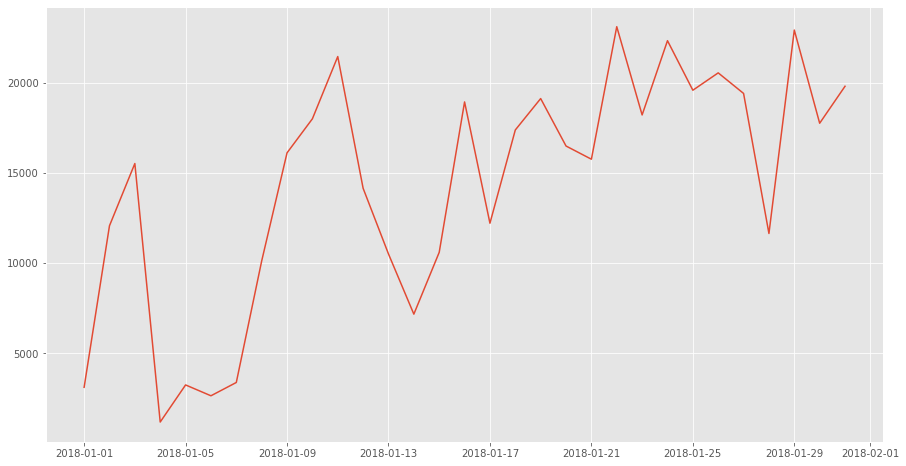

In [19]:
pickups_day=df.groupby(['date'])['pickup'].count()
plt.figure(3)
plt.plot(pickups_day.index,pickups_day)

# Section2: Prediction Challenge

## Creating a dataset for the prediction

In order to perform a prediction of pickups in the following 24 hours, a dataset is going to be built containing the previous 2 months pickups as features.

In [20]:
data=df.groupby(['date','hour'])['pickup'].count()
df_pred=pd.DataFrame(data)
#df_pred=df_pred.reset_index(level=[0,1])
df_pred=df_pred.rename(columns={'pickup':'pickups'})
df_pred.head()

pickups
date       hour         
2018-01-01 0          64
           1         103
           2          57
           3          37
           4          20

We create a function for creating lagged features (see Appendix 1)

In [21]:
two_months=30*2*24
df_lagged=buildLaggedFeatures(df_pred, ['pickups'], lag=two_months)
df_lagged.head()

,,pickups,pickups_lag1,pickups_lag2,pickups_lag3,pickups_lag4,pickups_lag5,pickups_lag6,pickups_lag7,pickups_lag8,pickups_lag9,...,pickups_lag1431,pickups_lag1432,pickups_lag1433,pickups_lag1434,pickups_lag1435,pickups_lag1436,pickups_lag1437,pickups_lag1438,pickups_lag1439,pickups_lag1440
date,hour,,,,,,,,,,,,,,,,,,,,,


In [22]:
y=df_lagged['pickups']

In [23]:
col=np.arange(0,24,1)
col
x=df_lagged.drop(df_lagged.columns[col],axis=1)
x_and_y=x.copy()
x_and_y.insert(loc=0,column='pickups',value=y)
x.head()

,,pickups_lag24,pickups_lag25,pickups_lag26,pickups_lag27,pickups_lag28,pickups_lag29,pickups_lag30,pickups_lag31,pickups_lag32,pickups_lag33,...,pickups_lag1431,pickups_lag1432,pickups_lag1433,pickups_lag1434,pickups_lag1435,pickups_lag1436,pickups_lag1437,pickups_lag1438,pickups_lag1439,pickups_lag1440
date,hour,,,,,,,,,,,,,,,,,,,,,


In order to get the predictions of the next 24 hours, first 24 lagged columns have been dropped. This way, the model can predict without needing the 24 hours before. 

Including the number of pickups per hour of the previous 2 months means that  dataset has a high number of columns that are maybe not so useful and are just there adding data without value. In order to perform a dimension reduction, a PCA analysis is going to be performed. 

### PCA Analysis

In [24]:
from sklearn import decomposition
pca=decomposition.PCA()
pca.fit(x)

ValueError: Found array with 0 sample(s) (shape=(0, 1417)) while a minimum of 1 is required.

How many PC do we need in order to explain the 95% of the variance?

In [ ]:
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]
plt.figure(4)
plt.plot(range(len(expl)), cdf,color='b')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [ ]:
print(cdf[219])

It seems that with 220 features corresponding to the first 220 PC, 95% of the variance of the data can be explained. We don't need to use 1440 columns if with just 220, we can mainly explain the variance of the data. The loss of information is very small in this case.

### Creating a new dataset with the 220 first principal components

In [ ]:
pca_new=decomposition.PCA(n_components=220)
pca_new.fit(x)
X_reduced=pca_new.transform(x)

In [ ]:
X_df_reduced=pd.DataFrame(X_reduced)
X_df_reduced

In [ ]:
X_df_reduced.index=df_lagged.index

# Part 1
## Linear Regression Model - free train/test splitting

For performing the prediction, a regression model is going to be used. The Sklearn Linear Regression is going to be used

In [ ]:
split=int(0.7*len(X_df_reduced))
x_train=X_df_reduced[:split]
y_train=y[:split]
x_test=X_df_reduced[split:]
y_test=y[split:]

In [ ]:
from sklearn.linear_model import LinearRegression
regr=LinearRegression()
regr.fit(x_train,y_train)

We create a function for calculating the R squared of the model and other measures (see Appendix 2). 

In [ ]:
mae, mape, rmse, r_squared, adjustedr2 = compute_error(y_test, regr.predict(x_test))

print("Mean Absolute Error = ", mae)
print("Mean Absolute Percentage Error = ", mape)
print("R-squared = ", r_squared)
print("Adjusted R-squared = ", adjustedr2)
print("Root Mean Squared Error = ", rmse)

The model performed gets an R2 > 0.70. It can been accepted.

# Part 2
## Linear Regression Model - specific train/test splitting

In [ ]:
X_df_reduced=X_df_reduced.reset_index(level=[0,1])
trainset_start=X_df_reduced[(X_df_reduced['date']=='2018-11-01')& (X_df_reduced['hour']==0)].index
trainset_start=trainset_start.values[0]

In [ ]:
x_test2=X_df_reduced.iloc[:trainset_start,2:]
x_train2=X_df_reduced.iloc[trainset_start:,2:]
y_test2=y.iloc[:trainset_start]
y_train2=y.iloc[trainset_start:]

In [ ]:
from sklearn.linear_model import LinearRegression
regr2=LinearRegression()
regr2.fit(x_train2,y_train2)

In [ ]:
mae, mape, rmse, r_squared, adjustedr2 = compute_error(y_test2, regr2.predict(x_test2))

print("Mean Absolute Error = ", mae)
print("Mean Absolute Percentage Error = ", mape)
print("R-squared = ", r_squared)
print("Adjusted R-squared = ", adjustedr2)
print("Root Mean Squared Error = ", rmse)

R-squared is a statistical measure of how close the data are to the fitted regression line. Getting a R-squared of 0 means that the model explains none of the variability of the response data around its mean. Using just the mean of the pickups per day would be even a better prediction in this case. This model can't obviously be considered as a useful model.

A possible reason for the low score could be that the train distribution is different than the test distribution. In order to consider this hypothesis and perform testing on how much this train-test distribution mismatch is affecting the results, we tried ignoring the temporal order of the observations and shuffling the dataset to perform a random split. 

As it can be observed in Appendix 3, shuffling the dataset is not giving better results (R-squared =  0). This could be a deeper subject for analysis to get the causes. Further explanation can be found in the Appendix 3. 

In [ ]:
from sklearn.linear_model import LinearRegression
regr3=LinearRegression()
regr3.fit(x_train3,y_train3)

## Appendix 3

In [ ]:
import sklearn
from sklearn.utils import shuffle
x_and_y=sklearn.utils.shuffle(x_and_y)
y=x_and_y['pickups']

In [ ]:
len_train=len(x_train2)
len_test=len(x_test2)
x_test3=x_and_y.iloc[:len_test,1:]
x_train3=x_and_y.iloc[len_test:,1:]
y_test3=y[:len_test]
y_train3=y[len_test:]

In [ ]:
from sklearn.linear_model import LinearRegression
regr3=LinearRegression()
regr3.fit(x_train3,y_train3)

In [ ]:
mae, mape, rmse, r_squared, adjustedr2 = compute_error(y_test3, regr3.predict(x_test3))

print("Mean Absolute Error = ", mae)
print("Mean Absolute Percentage Error = ", mape)
print("R-squared = ", r_squared)
print("Adjusted R-squared = ", adjustedr2)
print("Root Mean Squared Error = ", rmse)

We have also performed other test training with 3 months instead of 2 months. Those results have been better and the bigger the train set, higher the scores obtained. So in this case we are going to consider that training a model with the last two months of a year in order to predict the first 10 months of the year can't be considered as a good approach to build a model. Because of the difference of distributions of train/test data but also and mainly because of the train/test size difference. With just 2 months of training data, the model doesn't seem to be able to perform correct predictions. 

When we train a machine learning model, we don’t just want it to learn to model the training data. We want it to generalize to data it hasn’t seen before. In order to perform good prediction on the the new data, the goal of a machine learning model is to generalize patterns in training data so that you can correctly predict. Working with small training datasets can lead to 'overfitting'. Overfitting occurs when a model adjusts excessively to the training data, seeing patterns that do not exist, and consequently performing poorly in predicting new data. This could be one of the reasons our model is not working in Part 2. There are different techniques in order to prevent overfitting as using cross-validation, train with more data, remove features, early stopping, regularization or ensembling. Trying to find the adecuates ones for this prediction question could be a future topic of research to deep on it.

## End of Appendix 3

# Section 3: Exploratory Component

Unlike on the previous question, in this section we are going to try the determine the influence of the environmental, periodic and seasonal trends in the number of pickups. This information could help to better perform future predictions adding those data to the inputs.

On this purpose, we are going to use some extra information that it was not on the original dataset.
- A file containing weather information of New York during 2018. Unfortunately, this file only contains daily information so our analysis has to be reduced to daily numbers of pickups instead of doing it per hour.
- Holidays days in New York are also going to be included loading a holidays file. 
- Additionally, some trends indicators are going to be added as if it is a weekend day or not or the season of the year it is.

The aim of adding this information is because it is simple information that can be very easily obtained and in case of determinig that it is useful, it could help in future predictions decreasing the errors with low effort of obtaining them. 

## New data

In [ ]:
weather=pd.read_csv('weather_2018.csv')
weather.head()

In [ ]:
weather['avg_degree']=(weather['average temperature']-32)/1.8
weather=weather.set_index('date')

Some transformation to have ºC instead of ºF

In [ ]:
weather['precipitation']=weather['precipitation'].replace({'T':0.00})
weather['precipitation']=weather['precipitation'].replace({'0':0.00})

Some values are presented as 'T' which represents traces but so low that couldn't be measured. They are replaced by a 0 value instead

In [ ]:
weather=weather.drop(columns=['maximum temperature','minimum temperature','snow depth','snow fall','average temperature','Unnamed: 0'])
weather.head()

We are just going to focus on the temperature data and in the presence or absence of rain.

In [ ]:
holidays=pd.read_csv('holidays_2018.csv')
holidays.head()

In [ ]:
holidays=holidays.set_index('Date')
holidays=holidays.drop(columns=['Day','Unnamed: 0','Holiday'])
holidays['holiday']=1

In [ ]:
data_exp=df.groupby(['date'])['pickup'].count()
df_exp=pd.DataFrame(data_exp)
df_exp.head()

In [ ]:
df_exp=df_exp.merge(weather, on=weather.index)
df_exp=df_exp.set_index('key_0')

In [ ]:
df_exp['weekend'] = ((pd.DatetimeIndex(df_exp.index).dayofweek) // 5 == 1).astype(int)
df_exp['holiday']=0
for i in holidays.index:
    df_exp.loc[i,'holiday']=1
df_exp.index.names=['Date']

In [ ]:
df_exp.index=pd.to_datetime(df_exp.index)
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
df_exp['season']=df_exp.index.month.map(month_to_season)

A DataFrame has been generated containing the number of pickups per day, the rain indicator, the average temperature, a weekend indicator, a holiday indicator and a season indicator. 

## Behavior correlation

Some comparisons are going to be performed in order to identify different patterns depending on the new data added:


### Number of pickups depending on the day type

The bike-sharing system could be used mostly for 2 special types of travels: amusement or routine travels (office, school, gym...)

In [ ]:
plt.figure()
plt.figure(figsize=(15,5))
plt.bar(average_pickups_hour.index,average_pickups_hour['pickups'])
plt.axhline(y=3000,color='b')
plt.vlines([18,8,9,16,17,19],ymin=0,ymax=5000,color='b')
plt.show()

The highest numbers per hour are achieved in the hours were people use to performs those routine travels described above. In order to go deep on this believe, more analysis depending on the day type are going to be performed.

In [ ]:
weekend=['Not weekend','Weekend']
plt.figure(4)
plt.bar(weekend,df_exp.groupby('weekend')['pickup'].sum()/df_exp.groupby('weekend')['pickup'].count())

Against 'intuitive' logic, the average number of pickups is a 25% higher during the week than in weekends.

In [ ]:
holiday=['Not holiday','Holiday']
plt.figure(2)
plt.bar(holiday,df_exp.groupby('holiday')['pickup'].sum()/df_exp.groupby('holiday')['pickup'].count())

Apparently, there is no relation between being a holiday and an increase of the number of pickups. In fact, there is a slight decrease in the average number of pickups. This could be explained, along with the weekend analysis, because this bike-sharing is highly used also for routine and usual transportation (work, school...)

### Number of pickups depending on seasonal weather

The number of pickups could depend on the weather conditions as biking means being exposed to weather conditions.

In [ ]:
seasons=['Winter','Spring','Summer','Autumn']
plt.figure(1)
plt.bar(seasons,df_exp.groupby('season')['pickup'].sum())

The total number of pickups varies depending on the season of the year. Summer has the highest average while winter has the lowest one. This could be related to weather conditions as temperature or rain depending on the season. 

In [ ]:
rain_days=df_exp[df_exp['precipitation']>0]
pickups_day=df.groupby(['date'])['pickup'].count()
plt.figure(5)
plt.plot(pickups_day.index,pickups_day)
plt.scatter(rain_days.index,rain_days['pickup'],c='b')

Apparently there is no clear pattern indicating that raining days decrease the number of pickups. However, the plot above doesn't allow to precisely relate information since it represents a high number of days and the representation can be unclear. To verify this information, some correlations calculations are going to performed. 

In [ ]:
import seaborn as sn
data=df_exp[['pickup','precipitation']]
corrMatrix=data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can confirm that precipitations aren't too correlated with the precipitation levels. This could be explained as the bike-sharing system is mainly used for necessary displacements.

Performing some research analysis, it has been verified that apparently, when talking about weather 'problems' of NYC, the main problem comes with the temperature and its cold values in some seasons. We can verify then if as it's said, the temperature has a relevant role in the number of pickups. 

In [ ]:
data2=df_exp[['pickup','avg_degree']]
corrMatrix2=data2.corr()
sn.heatmap(corrMatrix2, annot=True)
plt.show()

We observe that there is a relation between temperature and number of pickups. This means that in warm days people are more prone to use the bike than in cold days.

# Section4: Conclusions

First of all, the dataset has been transformed to a clean one. Observations with missing values have been deleted. Values detected as outliers for columns as 'tripduration' or the geografical coordinates have been removed. Categorical features have been transformed with one-out-of-K encoding and dates formats have been converted to datetime format. 

For the prediction challenge, a "new" dataset with lagged values has been created. 

For Part 1, next 24 hours have been predicted using 2 months of lagged data. The R2 obtained is 0.75 which is higher than the benchmark.

However, on Part 2, 10 first month have been predicted using last 2 months. The R2 value is 0 so it means the model doesn't predict better than just using the mean of the pickups. Dataset has been shuffled in order to test if the different distribution between train/test sets is the cause, but new results have not improved the previous ones. 
As it has been mentionned, this can be caused by trying to train a model with such low ammount of data. In those cases, the model obtained is not able to be generalized to other data. It could happen that the model is overfitted, as it has been explained. 

Finally, on the Exploratory Component part, new external internet source data has been added to the dataset: holidays and weather data. The goal was to determine the influence of the environmental, the periodic and the seasonal trends in the number of pickups. 

It has been detected that this bike sharing system is mostly used for necessary and routine travels rather than amusement ones. Moreover, it has been observed that the average number of pickups strongly deppends on the season of the year. Not so much because of the rain, but mainly because of the temperature. The highest the temperature, highest the number of pickups.

This new information could help to perform better predictions just by adding features representing the predictions of temperature or indicators of rush hours.

# Individual contributions
We decided that we were going to do this group project all together, thus every individual contribution is the same: 33.33% for each one of us. 
- Carles Alfageme: 33.33%
- Joos Benrath: 33.33%
- Elena Vico: 33.33%